In [1]:
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc3 as pm
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import tqdm
import pandas as pd
from scipy import stats
import seaborn as sns

import DeadTime

sns.set(font_scale=1.6)

%matplotlib inline

%load_ext version_information

%version_information pymc3, scipy



This unreleased version of SpacePy is not supported by the SpacePy team.


Software versions
Python 3.7.3 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.5.0
OS Darwin 18.5.0 x86_64 i386 64bit
pymc3 3.6
scipy 1.2.1
Fri May 17 14:50:00 2019 MDT

In [2]:
DT = DeadTime.TimeStamps(size=1000000)
DT.apply_nonpar_deadtime(1e-1)

In [3]:
TS = DeadTime.TimeSeries(DT)

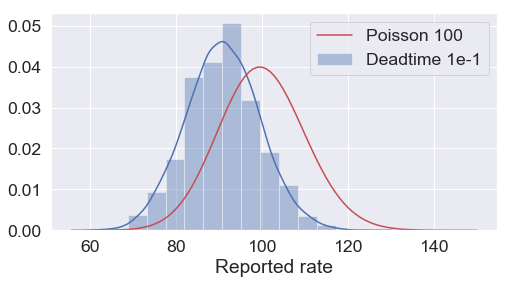

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.distplot(TS.timeseries, 15, label=('Deadtime 1e-1'));
XX = np.arange(60, 151)
plt.plot(XX, stats.poisson(100).pmf(XX), 'r', label='Poisson 100')
plt.legend()
plt.xlabel('Reported rate')
kde = stats.gaussian_kde(TS.timeseries)
# plt.plot(XX, kde.evaluate(XX), 'g')

In [18]:
def dist_from_hist(param, kde, xlim=(50,150), N=100):
    width = xlim[1] - xlim[0]
    x = np.linspace(xlim[0], xlim[1], N)
    y = kde.evaluate(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.distributions.Interpolated(param, x, y)

In [19]:
with pm.Model() as model:
    # Priors are posteriors from previous iteration
    dat = dist_from_hist('dat', kde)

    # draw 10000 posterior samples
    trace = pm.sample(10000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dat]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5193.18draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f4b2940>,
      dtype=object)

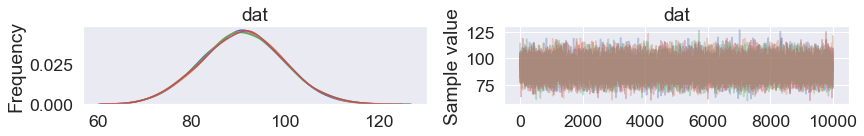

In [20]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20a910b8>,
      dtype=object)

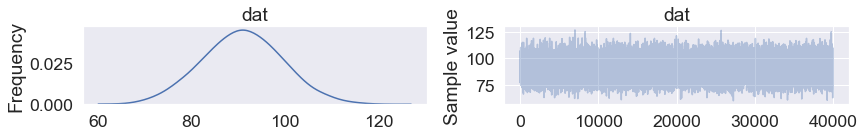

In [21]:
pm.traceplot(trace, combined=True)

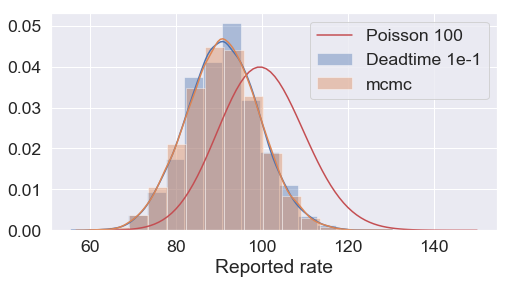

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.distplot(TS.timeseries, 15, label=('Deadtime 1e-1'));
XX = np.arange(60, 151)
plt.plot(XX, stats.poisson(100).pmf(XX), 'r', label='Poisson 100')
plt.xlabel('Reported rate')
kde = stats.gaussian_kde(TS.timeseries)

sns.distplot(trace['dat'], 15, label='mcmc')

plt.legend()
